[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ianjure/markov-chain-trading/blob/main/Markov_Chain_Notebook.ipynb)

**Author:** Ian Jure Macalisang

**Email:** ianjuremacalisang2@gmail.com

**Link:** https://github.com/ianjure/markov-chain-trading

**Website:** https://tradestrats.streamlit.app/

# **I. Collecting the Data**

In [17]:
# Importing libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [106]:
ticker = 'AAPL'
stock = yf.Ticker(ticker)
stock = stock.history(period='max')

# **II. Preprocessing the Data**

In [107]:
def preprocess(stock):
    # Drop unnecessary columns
    del stock["Dividends"]
    del stock["Stock Splits"]

    # Convert the index to a datetime object
    stock.index = stock.index.strftime('%Y-%m-%d')
    stock.index = pd.to_datetime(stock.index)

    # Calculate daily returns
    stock["Daily Returns"] = stock["Close"].pct_change()

    # Create the current and future state columns
    conditions = [stock["Daily Returns"] > 0.005, stock["Daily Returns"] < 0]
    stock["CurrentState"] = np.select(conditions, ["Up", "Down"], default="Neutral")
    stock["FutureState"] = stock["CurrentState"].shift(-1)

    return stock

In [108]:
stock = preprocess(stock)
stock.tail()

,Open,High,Low,Close,Volume,Daily Returns,CurrentState,FutureState
Date,,,,,,,,
2024-08-27,226.000000,228.850006,224.889999,228.029999,35934600,0.003742,Neutral,Down
2024-08-28,227.919998,229.860001,225.679993,226.490005,38052200,-0.006753,Down,Up
2024-08-29,230.100006,232.919998,228.880005,229.789993,51906300,0.014570,Up,Down
2024-08-30,230.190002,230.399994,227.479996,229.000000,52990800,-0.003438,Down,Down
2024-09-03,228.550003,229.000000,221.169998,222.770004,50042900,-0.027205,Down,None


# **III. Building the Transition Matrix**

$$
\begin{bmatrix}
P(Up \to Up) & P(Up \to Neutral) & P(Up \to Down)\\
P(Neutral \to Up) & P(Neutral \to Neutral) & P(Neutral \to Down)\\
P(Down \to Up) & P(Down \to Neutral) & P(Down \to Down)
\end{bmatrix}
$$

<br>

We will now calculate the probabilities of transitioning from one state to another based on historical data. These probabilities are the entries in the transition matrix.

In [124]:
def create_transition_matrix(stock):
    # Count all occurences of each states
    up_count = len(stock.query('CurrentState == "Up"'))
    neutral_count = len(stock.query('CurrentState == "Neutral"'))
    down_count = len(stock.query('CurrentState == "Down"'))

    # Count all transitions from up to other states
    up_to_up = len(stock.query('CurrentState == "Up" and FutureState == "Up"'))
    up_to_neutral = len(stock.query('CurrentState == "Up" and FutureState == "Neutral"'))
    up_to_down = len(stock.query('CurrentState == "Up" and FutureState == "Down"'))

    # Count all transitions from neutral to other states
    neutral_to_up = len(stock.query('CurrentState == "Neutral" and FutureState == "Up"'))
    neutral_to_neutral = len(stock.query('CurrentState == "Neutral" and FutureState == "Neutral"'))
    neutral_to_down = len(stock.query('CurrentState == "Neutral" and FutureState == "Down"'))

    # Count all transitions from down to other states
    down_to_up = len(stock.query('CurrentState == "Down" and FutureState == "Up"'))
    down_to_neutral = len(stock.query('CurrentState == "Down" and FutureState == "Neutral"'))
    down_to_down = len(stock.query('CurrentState == "Down" and FutureState == "Down"'))

    # Calculate the transition probabilities from up
    prob_up_to_up = up_to_up / up_count
    prob_up_to_neutral = up_to_neutral / up_count
    prob_up_to_down = up_to_down / up_count

    # Calculate the transition probabilities from neutral
    prob_neutral_to_up = neutral_to_up / neutral_count
    prob_neutral_to_neutral = neutral_to_neutral / neutral_count
    prob_neutral_to_down = neutral_to_down / neutral_count

    # Calculate the transition probabilities from neutral
    prob_down_to_up = down_to_up / down_count
    prob_down_to_neutral = down_to_neutral / down_count
    prob_down_to_down = down_to_down / down_count

    # Create the transition matrix
    up_prob_list = [prob_up_to_up, prob_up_to_neutral, prob_up_to_down]
    neutral_prob_list = [prob_neutral_to_up, prob_neutral_to_neutral, prob_neutral_to_down]
    down_prob_list = [prob_down_to_up, prob_down_to_neutral, prob_down_to_down]

    transition_matrix = pd.DataFrame([up_prob_list, neutral_prob_list, down_prob_list],
                                    columns=['Up', 'Neutral', 'Down'],
                                    index=['Up', 'Neutral', 'Down'])

    return transition_matrix

In [125]:
transition_matrix = create_transition_matrix(stock)
transition_matrix

,Up,Neutral,Down
Up,0.420775,0.116857,0.462368
Neutral,0.383800,0.145344,0.470855
Down,0.412061,0.115765,0.471980


Use the matrix to make a decision based on the current state by selecting the one with the highest probability in the current state's row.

In [127]:
# Checking the current state
current_state = stock.iloc[-1]["CurrentState"]
print(f"Current state: {current_state}")

# Get the probability of the transition from current to future state
prob = transition_matrix.loc[current_state]

# Get the maximum probability
print(f"Maximum probability: {round(max(prob), 2)}")

# Get the index of the maximum probability
print(f"Index of the maximum probability: {prob.idxmax()}")

print(f"\nUsing the matrix we found that there is a {round(max(prob), 2) * 100}% chance that the stock price will go {prob.idxmax()} tomorrow.")

Current state: Down
Maximum probability: 0.47
Index of the maximum probability: Down

Using the matrix we found that there is a 47.0% chance that the stock price will go Down tomorrow.


# **IV. Simulating the Strategy**

We will now simulate the strategy by backtesting it against one year of the stock's historical data. However, trades will only be executed if the probability exceeds our predefined threshold.

In [130]:
def run_simulation(stock, amount, threshold, interval="1d", verbose=False):

    """
    Simulates the execution of a Markov chain trading strategy.

    Args:
        stock (pd.DataFrame): Historical stock data used for simulation. The DataFrame should be from Yahoo Finance.
        amount (int): The initial capital available for investment.
        threshold (float): The probability threshold for making a trade decision. Trades are executed when this threshold is met or exceeded.
        interval (str): The time interval between trades, specified in days. Valid options are '1d', '2d', '5d', or '10d'.
        verbose (bool): If True, detailed information about the simulation results are displayed.

    Returns:
        None: The function generates and displays a plot of the simulated trades and their expected returns.
    """

    # Initialize trading variables
    initial_amount = amount
    total_amount = amount

    # Preprocess the stock data
    stock = preprocess(stock)

    # Initialize starting date (must be 1 year before the present date)
    latest_date = stock.index[-1]
    start_year = int(str(latest_date)[0:4]) - 1
    start_date = f"{start_year}" + str(latest_date)[4:]

    # Convert the start date to a datetime object
    start_date = pd.to_datetime(start_date)
    stock = stock.loc[start_date:]

    # Initialize the plot
    plt.figure(figsize = (20, 5), facecolor='white')
    plt.title(f"{ticker} Stock Price", fontsize=20, color='black')
    plt.plot(stock["Close"])

    # Create a dictionary for trade actions
    trade_actions = {
        "Buy": 0,
        "Hold": 0,
        "Sell": 0,
        "Total Actions": 0
    }

    # Create a dictionary for trade status
    trade_status = {
        "Win": 0,
        "Lose": 0,
    }

    # Set the interval
    if interval == "1d":
        interval = 1
    elif interval == "2d":
        interval = 2
    elif interval == "5d":
        interval = 5
    elif interval == "10d":
        interval = 10
    else:
        raise ValueError("Invalid interval. Must be 1d, 2d, 5d, or 10d.")

    for i in range(50, stock.shape[0], interval):
        # Define a range for the transition matrix
        train = stock.iloc[0:i].copy()

        # Create the transition matrix
        transition_matrix = create_transition_matrix(train)

        # Get the current state
        current_state = train.iloc[-1]["CurrentState"]

        # Get the probability of the transition from current to future state
        prob = transition_matrix.loc[current_state]

        # Check if the maximum probability is higher than the threshold
        if max(prob) >= threshold:

            # Get the index of the maximum probability
            max_prob = prob.idxmax()

            # Draw trade lines, increment trade actions/status, and calculate the loss/profit
            if max_prob == "Up":
                # Action: Buy
                trade_actions["Buy"] += 1
                trade_actions["Total Actions"] += 1

                # Get current day's closing price
                buying_price = train.iloc[-1]["Close"]

                # Get tomorrow's closing price
                if i != stock.shape[0]:
                    market_price = stock.iloc[i]["Close"]
                else:
                    continue

                # Check if it is a losing or a winning trade
                if buying_price > market_price:

                    # Buying Price > Market Price (Selling Price) is a losing trade
                    plt.axvline(x=train.index[-1], color = 'r', lw=0.5)

                    # Calculate the loss
                    trade_loss = buying_price - market_price
                    total_amount = total_amount - trade_loss

                    # Update trade status
                    trade_status["Lose"] += 1

                else:
                    # Buying Price < Market Price (Selling Price) is a winning trade
                    plt.axvline(x=train.index[-1], color = 'g', lw=0.5)

                    # Calculate the profit
                    trade_profit = market_price - buying_price
                    total_amount = total_amount + trade_profit

                    # Update trade status
                    trade_status["Win"] += 1

            elif max_prob == "Neutral":
                # Action: Hold or None
                trade_actions["Hold"] += 1
                trade_actions["Total Actions"] += 1

            elif max_prob == "Down":
                # Action: Sell
                trade_actions["Sell"] += 1
                trade_actions["Total Actions"] += 1

                # Get current day's closing price
                selling_price = train.iloc[-1]["Close"]

                # Get tomorrow's closing price
                if i != stock.shape[0]:
                    market_price = stock.iloc[i]["Close"]
                else:
                    continue

                # Check if it is a losing or a winning trade
                if selling_price < market_price:

                    # Selling Price < Market Price (Buying Price) is a losing trade
                    plt.axvline(x=train.index[-1], color = 'r', lw=0.5)

                    # Calculate the loss
                    trade_loss = market_price - selling_price
                    total_amount = total_amount - trade_loss

                    # Update trade status
                    trade_status["Lose"] += 1

                else:
                    # Selling Price > Market Price (Buying Price) is a winning trade
                    plt.axvline(x=train.index[-1], color = 'g', lw=0.5)

                    # Calculate the profit
                    trade_profit = selling_price - market_price
                    total_amount = total_amount + trade_profit

                    # Update trade status
                    trade_status["Win"] += 1

    # Show simulation results
    if verbose:
        plt.annotate(f'Buy: {trade_actions["Buy"]}   Hold: {trade_actions["Hold"]}   Sell: {trade_actions["Sell"]}', xy=(20, 370), xycoords='axes pixels', fontsize=12, ha='left', va='top')
        plt.annotate(f'Total Actions: {trade_actions["Total Actions"]}', xy=(20, 350), xycoords='axes pixels', fontsize=12, ha='left', va='top')

        if trade_status["Win"] == 0 and trade_status["Lose"] == 0 :
            plt.annotate(f'Win: 0   Lose: 0   Win Rate: 0%', xy=(20, 310), xycoords='axes pixels', fontsize=12, ha='left', va='top')
        else:
            plt.annotate(f'Win: {trade_status["Win"]}   Lose: {trade_status["Lose"]}   Win Rate: {round((trade_status["Win"] / (trade_status["Win"] + trade_status["Lose"])) * 100, 2)}%', xy=(20, 310), xycoords='axes pixels', fontsize=12, ha='left', va='top')

        plt.annotate(f'Total Profit: {round(total_amount - initial_amount, 2)}$', xy=(20, 290), xycoords='axes pixels', fontsize=12, ha='left', va='top')
        plt.annotate(f'Total Amount: {round(total_amount, 2)}$', xy=(20, 270), xycoords='axes pixels', fontsize=12, ha='left', va='top')

    else:
        if trade_status["Win"] == 0 and trade_status["Lose"] == 0 :
            plt.annotate(f'Win: 0   Lose: 0   Win Rate: 0%', xy=(20, 370), xycoords='axes pixels', fontsize=12, ha='left', va='top')
        else:
            plt.annotate(f'Win: {trade_status["Win"]}   Lose: {trade_status["Lose"]}   Win Rate: {round((trade_status["Win"] / (trade_status["Win"] + trade_status["Lose"])) * 100, 2)}%', xy=(20, 370), xycoords='axes pixels', fontsize=12, ha='left', va='top')

        plt.annotate(f'Total Profit: {round(total_amount - initial_amount, 2)}$', xy=(20, 350), xycoords='axes pixels', fontsize=12, ha='left', va='top')
        plt.annotate(f'Total Amount: {round(total_amount, 2)}$', xy=(20, 330), xycoords='axes pixels', fontsize=12, ha='left', va='top')

    return plt.show()

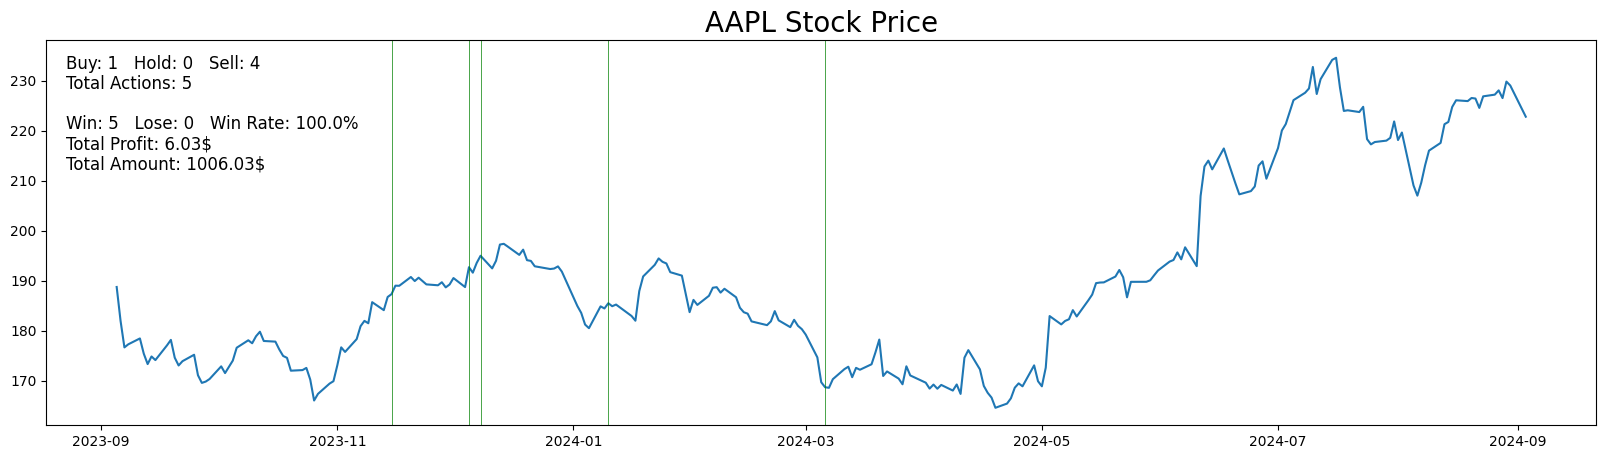

In [131]:
ticker = 'AAPL'
stock = yf.Ticker(ticker)
stock = stock.history(period='max')

run_simulation(stock=stock, amount=1000, threshold=0.55, interval="1d", verbose=True)